# EGFxSet: numerical and visual analysis

In [14]:
import sys
sys.path.append('../')

import os
import random
import numpy as np
import pandas as pd
import soundfile as sf
import pyloudnorm as pyln
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.signal import spectrogram
from src.data.egfxset import load_egfxset

plt.style.use('ggplot')
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 100    
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5

pd.set_option('display.float_format', '{:.6f}'.format)

In [15]:
# Setting up the directories and the sample rate

DATA_DIR = Path('../data/raw/')
RESULTS_DIR = Path('../data/features/')
PLOTS_DIR = Path('../docs/plots/')

dry_samples_path = os.path.join(DATA_DIR, "egfxset/Clean")
wet_samples_path = os.path.join(DATA_DIR, "egfxset/Spring Reverb")

sample_rate = 48000

In [16]:
seed = 42  # You can choose any seed value
random.seed(seed)
np.random.seed(seed)

In [17]:
# Retrieve wav files
def retrieve_wav_files(directory):
    """
    Retrieve all the files in a directory and its subdirectories
    :param directory: the directory to search
    :return: a list of files
    """
    wav_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    wav_files.sort()
    return wav_files

In [18]:
# Make file lists
dry_files = retrieve_wav_files(dry_samples_path)
wet_files = retrieve_wav_files(wet_samples_path)

print(f"Number of dry samples: {len(dry_files)}")
print(f"Number of wet samples: {len(wet_files)}")

Number of dry samples: 690
Number of wet samples: 690


In [19]:
# Function to calculate duration and size
def calculate_duration_and_size(file_list):
    total_duration = 0.0    # in seconds
    total_size = 0          # in bytes

    for file_path in file_list:
        info = sf.info(file_path)

        # Calculate duration in seconds
        duration_seconds = info.frames / info.samplerate

        total_duration += duration_seconds
        total_size += os.path.getsize(file_path)

    # Convert total duration to minutes and seconds
    total_minutes = int(total_duration // 60)
    total_seconds = int(total_duration % 60)

    # Convert total size to megabytes
    total_megabytes = total_size / (1024 * 1024)

    return total_minutes, total_seconds, total_megabytes

# Calculate duration and size
dry_minutes, dry_seconds, dry_megabytes = calculate_duration_and_size(dry_files)
wet_minutes, wet_seconds, wet_megabytes = calculate_duration_and_size(wet_files)

# Print the results
print(f"Dry Samples: {dry_minutes} minutes, {dry_seconds} seconds, {dry_megabytes:.2f} MB")
print(f"Wet Samples: {wet_minutes} minutes, {wet_seconds} seconds, {wet_megabytes:.2f} MB")

Dry Samples: 57 minutes, 30 seconds, 475.80 MB
Wet Samples: 57 minutes, 30 seconds, 475.74 MB


## DC offset

\begin{equation}
\text{DC Offset} = \frac{1}{N} \sum_{i=1}^{N} x_i
\end{equation}

## Root-Mean-Square (RMS)

\begin{equation}
\text{RMS} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2}
\end{equation}

In [20]:
# Compute features

def compute_features(audio_file):
    data, sample_rate = sf.read(audio_file)

    length = len(data) / sample_rate
    min_val = np.min(data)
    max_val = np.max(data)
    dc_offset = np.mean(data)
    rms = np.sqrt(np.mean(data ** 2))
    rms_db = 20 * np.log10(rms)
    
    meter = pyln.Meter(sample_rate) # create BS.1770 meter
    loudness = meter.integrated_loudness(data)
    
    return length, min_val, max_val, dc_offset, rms_db, loudness

In [21]:
def store_features_to_csv(audio_files, csv_filename, root_directory):
    with open(csv_filename, 'w') as f:
        # Write the header row
        f.write("file,length,min,max,dc,rms,loudness\n")
        
        for audio_file in audio_files:
            length, min_val, max_val, dc_offset, rms, loudness = compute_features(audio_file)
            # Calculate the relative path from the root folder
            relative_path = os.path.relpath(audio_file, root_directory)
            f.write(f"{relative_path},{length},{min_val},{max_val},{dc_offset},{rms},{loudness}\n")

# Specify the output CSV filenames
dry_csv_filename = Path(RESULTS_DIR) / "egfxset_dry.csv"
wet_csv_filename = Path(RESULTS_DIR) / "egfxset_wet.csv"

# Call the function for dry and wet files
store_features_to_csv(dry_files, dry_csv_filename, DATA_DIR)
store_features_to_csv(wet_files, wet_csv_filename, DATA_DIR)

In [22]:
# Load data into DataFrames

dry_df = pd.read_csv(dry_csv_filename)
wet_df = pd.read_csv(wet_csv_filename)

In [23]:
dry_df.describe()

,length,min,max,dc,rms,loudness
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,5.000599,-0.913068,0.826371,0.000008,-21.515983,-19.696638
std,0.004343,0.102961,0.129357,0.000015,3.033696,2.566179
min,4.926354,-1.000000,0.408404,-0.000099,-32.341176,-27.641468
25%,5.000000,-0.994133,0.736166,0.000001,-23.292490,-21.353977
50%,5.000000,-0.949525,0.868652,0.000007,-21.085231,-19.553660
75%,5.000000,-0.881518,0.891056,0.000015,-19.391456,-17.890836
max,5.032896,-0.489084,0.999970,0.000079,-14.468344,-13.084712


In [24]:
wet_df.describe()

,length,min,max,dc,rms,loudness
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,5.000000,-0.880692,0.674438,-0.000000,-21.558489,-19.299191
std,0.000000,0.025691,0.133131,0.000003,3.894871,3.353665
min,5.000000,-0.891229,0.298416,-0.000047,-32.898991,-29.363441
25%,5.000000,-0.888406,0.572985,-0.000001,-24.395128,-21.598368
50%,5.000000,-0.885813,0.675539,-0.000000,-21.311010,-19.565592
75%,5.000000,-0.883181,0.775463,0.000000,-18.627541,-16.866260
max,5.000000,-0.585336,0.899238,0.000041,-12.258127,-10.105397


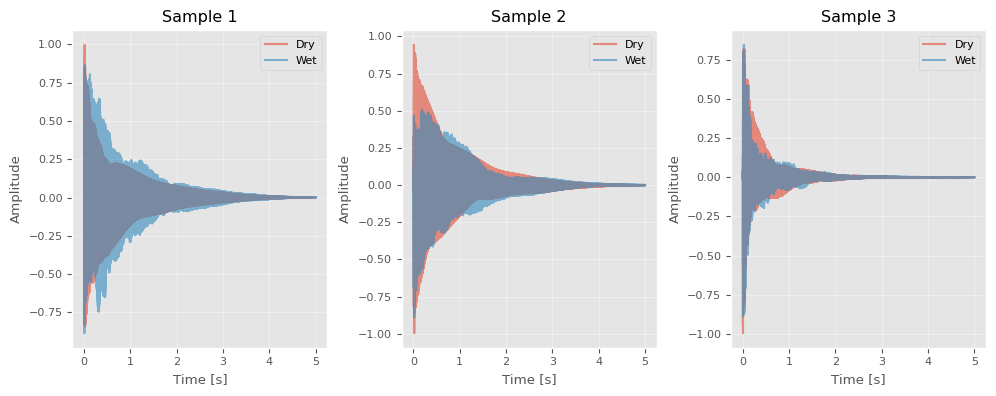

In [25]:
random_indices = random.sample(range(len(dry_files)), 3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
for i, index in enumerate(random_indices):
    dry_file = dry_files[index]
    wet_file = wet_files[index]
    
    # Load audio data from the files using sf.read()
    dry, _ = sf.read(dry_file)
    wet, _ = sf.read(wet_file)
    
    t = np.linspace(0, len(dry) / sample_rate, len(dry))


    axs[i].plot(t, dry, alpha=0.6, label="Dry")
    axs[i].plot(t, wet, alpha=0.6, label="Wet")
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Amplitude")
    axs[i].set_title(f"Sample {i + 1}")
    axs[i].grid(True)
    axs[i].legend()

# Show the plot
plt.tight_layout()  # Ensures that subplots don't overlap
plt.show()


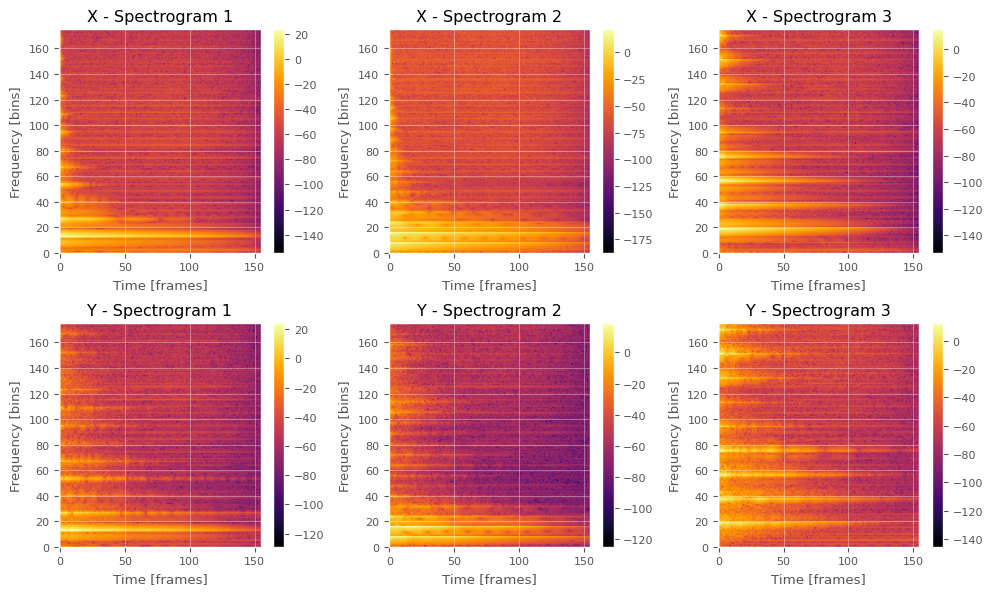

In [26]:
# Set the parameters
frameSize = 2048
hopSize = 512

# Create a figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
for i, index in enumerate(random_indices):
    
    dry_file = dry_files[index]
    wet_file = wet_files[index]
    
    # Load audio data from the files using sf.read()
    dry, _ = sf.read(dry_file)
    wet, _ = sf.read(wet_file)

    # Calculate the spectrograms for x and y
    _, _, Sxx_x = spectrogram(dry, nperseg=frameSize, noverlap=hopSize)
    _, _, Sxx_y = spectrogram(wet, nperseg=frameSize, noverlap=hopSize)

    frame_duration = frameSize / sample_rate

    # Plot the X spectrogram
    img_x = axs[0, i].imshow(10 * np.log10(Sxx_x), aspect='auto', origin='lower', cmap='inferno')
    axs[0, i].set_title(f"X - Spectrogram {i + 1}")
    axs[0, i].set_ylabel('Frequency [bins]')
    axs[0, i].set_xlabel('Time [frames]')
    axs[0, i].set_ylim(0, 175)
    plt.colorbar(img_x, ax=axs[0, i])

    # Plot the Y spectrogram
    img_y = axs[1, i].imshow(10 * np.log10(Sxx_y), aspect='auto', origin='lower', cmap='inferno')
    axs[1, i].set_title(f"Y - Spectrogram {i + 1}")
    axs[1, i].set_ylabel('Frequency [bins]')
    axs[1, i].set_xlabel('Time [frames]')
    axs[1, i].set_ylim(0, 175)
    plt.colorbar(img_y, ax=axs[1, i])

plt.tight_layout()
plt.show()